In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import importlib.resources as pkg_resources

from debvader import DeblendField, IterativeDeblendField

from debvader.model.model import load_deblender
from debvader.deblend_cutout.deblender import deblend
from debvader.detect.detection import detect_objects
from debvader.normalize.normalize import normalize_non_linear, denormalize_non_linear

### Deblend stamps randomly generated from DC2 data

Load 10 DC2 images centred on galaxy. They have been generated using this notebook: https://github.com/BastienArcelin/dc2_img_generation/blob/main/notebooks/dc2_stamps_and_corresponding_parameters.ipynb

In [3]:
import importlib.resources as pkg_resources
import os
import numpy as np

with pkg_resources.files('debvader').joinpath('data') as data_path:
    image_path = os.path.join(data_path, 'dc2_imgs/imgs_dc2.npy')
    images = np.load(image_path, mmap_mode='c')

/tmp/ipykernel_90200/3861427342.py:5: DeprecationWarning: pathlib.Path.__enter__() is deprecated and scheduled for removal in Python 3.13; Path objects as a context manager is a no-op
  with pkg_resources.files('debvader').joinpath('data') as data_path:


Visualize some of the images

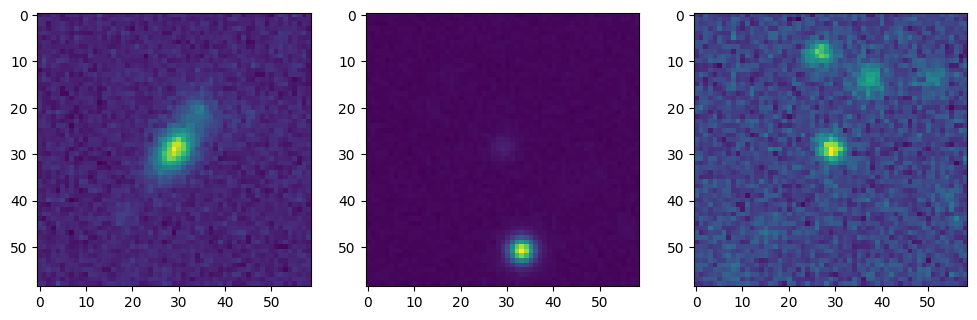

In [4]:
fig, axes = plt.subplots(1,3, figsize = (12, 4))
for i in range (3):
    axes[i].imshow(images[i,:,:,2]) # We plot only r-band here, but the images are multi-bands (ugrizy)

Now we can load the deblender

In [5]:
# First, define the parameters of the neural network, for this version of debvader, they are as follow:
nb_of_bands = 6
input_shape = (59, 59, nb_of_bands)
latent_dim = 32
filters = [32,64,128,256]
kernels = [3,3,3,3]

# We will load the weights of the network trained on DC2 images
survey = "dc2"

In [6]:
# Load the network using the load_deblender function
net, encoder, decoder, z = load_deblender(survey, input_shape, latent_dim, filters, kernels, return_encoder_decoder_z=True)

2024-11-05 02:23:42.939256: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3392 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6
2024-11-05 02:23:42.940500: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 16970 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:08:00.0, compute capability: 8.6


in cropping
/home/parlange/debvader/src/debvader/data/weights/dc2


In [7]:
# We can visualize the network
net.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 59, 59, 6)]       0         
                                                                 
 model (Functional)          (None, 560)               3741224   
                                                                 
 multivariate_normal_tri_l   ((None, 32),              0         
 (MultivariateNormalTriL)     (None, 32))                        
                                                                 
 model_1 (Functional)        (None, 59, 59, 6)         4577228   
                                                                 
Total params: 8318452 (31.73 MB)
Trainable params: 3741212 (14.27 MB)
Non-trainable params: 4577240 (17.46 MB)
_________________________________________________________________


We now have everything to do the deblending. Let's use our network to deblend the DC2 images

First let's normalize out images

In [8]:
# images_norm = normalize_non_linear(images)

Now we can do the deblending, and denormalize output images

In [9]:
output_images_mean, output_images_distribution = deblend(net, images)
# output_images_mean = denormalize_non_linear(output_images_mean)

2024-11-05 02:23:43.905132: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8800
2024-11-05 02:23:44.241507: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Here the network outputs a distribution over the pixels for each pixel in each filter, this is why both the mean image and the corresponding distribution is outputed.

Let's first visualize the mean images outputed by debvader.

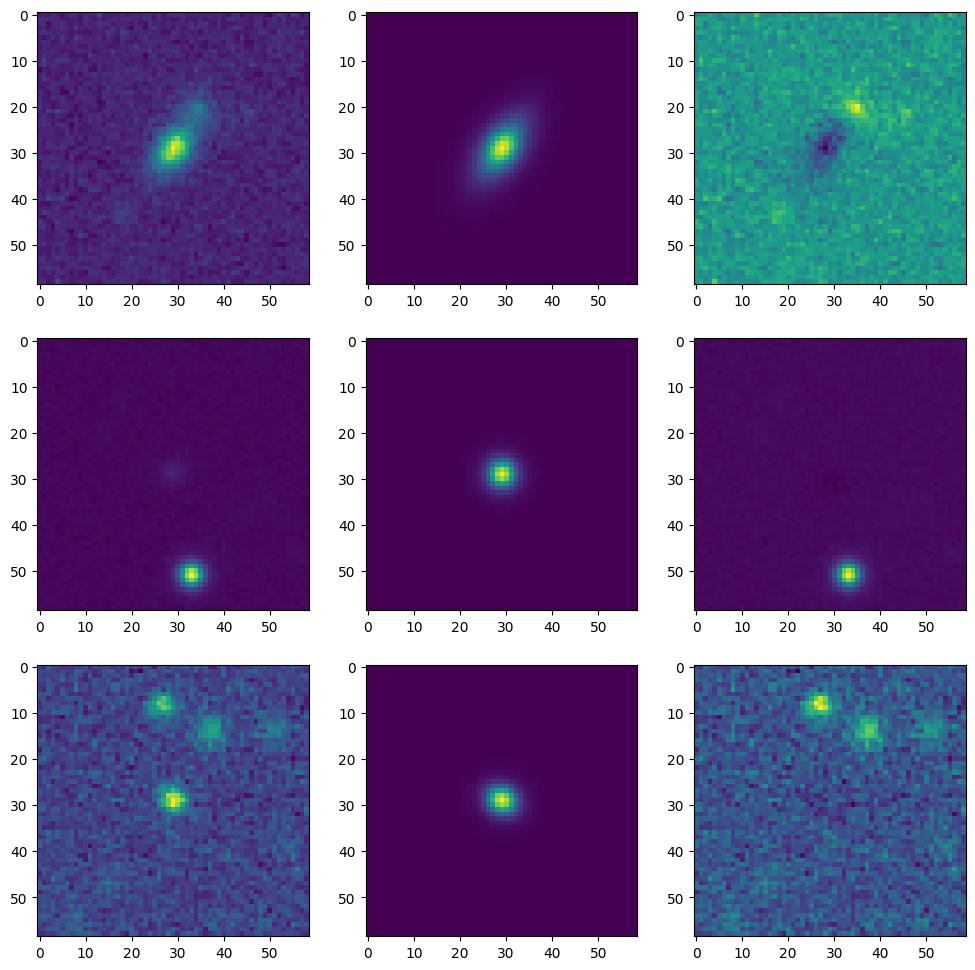

In [10]:
fig, axes = plt.subplots(3,3, figsize = (12, 12))
for i in range (3):
    axes[i,0].imshow(images[i,:,:,2]) # We plot only r-band here, but the images are multi-bands (ugrizy)
    axes[i,1].imshow(output_images_mean[i,:,:,2]) # We plot only r-band here, but the output images are multi-bands (ugrizy)
    axes[i,2].imshow(images[i,:,:,2]-output_images_mean[i,:,:,2])

Now we can look at what the images of the standard deviation look like for each example, and how we can sample this distribution in each pixel.

In [11]:
output_uncertainty_mean = output_images_distribution.mean().numpy() # Extract the mean of the distribution. Same image as output_images_mean.
output_uncertainty_std = output_images_distribution.stddev().numpy() # Extract the standard deviation of the distribution.
output_uncertainty_sample = tf.math.reduce_mean(output_images_distribution.sample(100), axis = 0).numpy() # Sample 100 times the distribution in each pixel and produce a mean image.

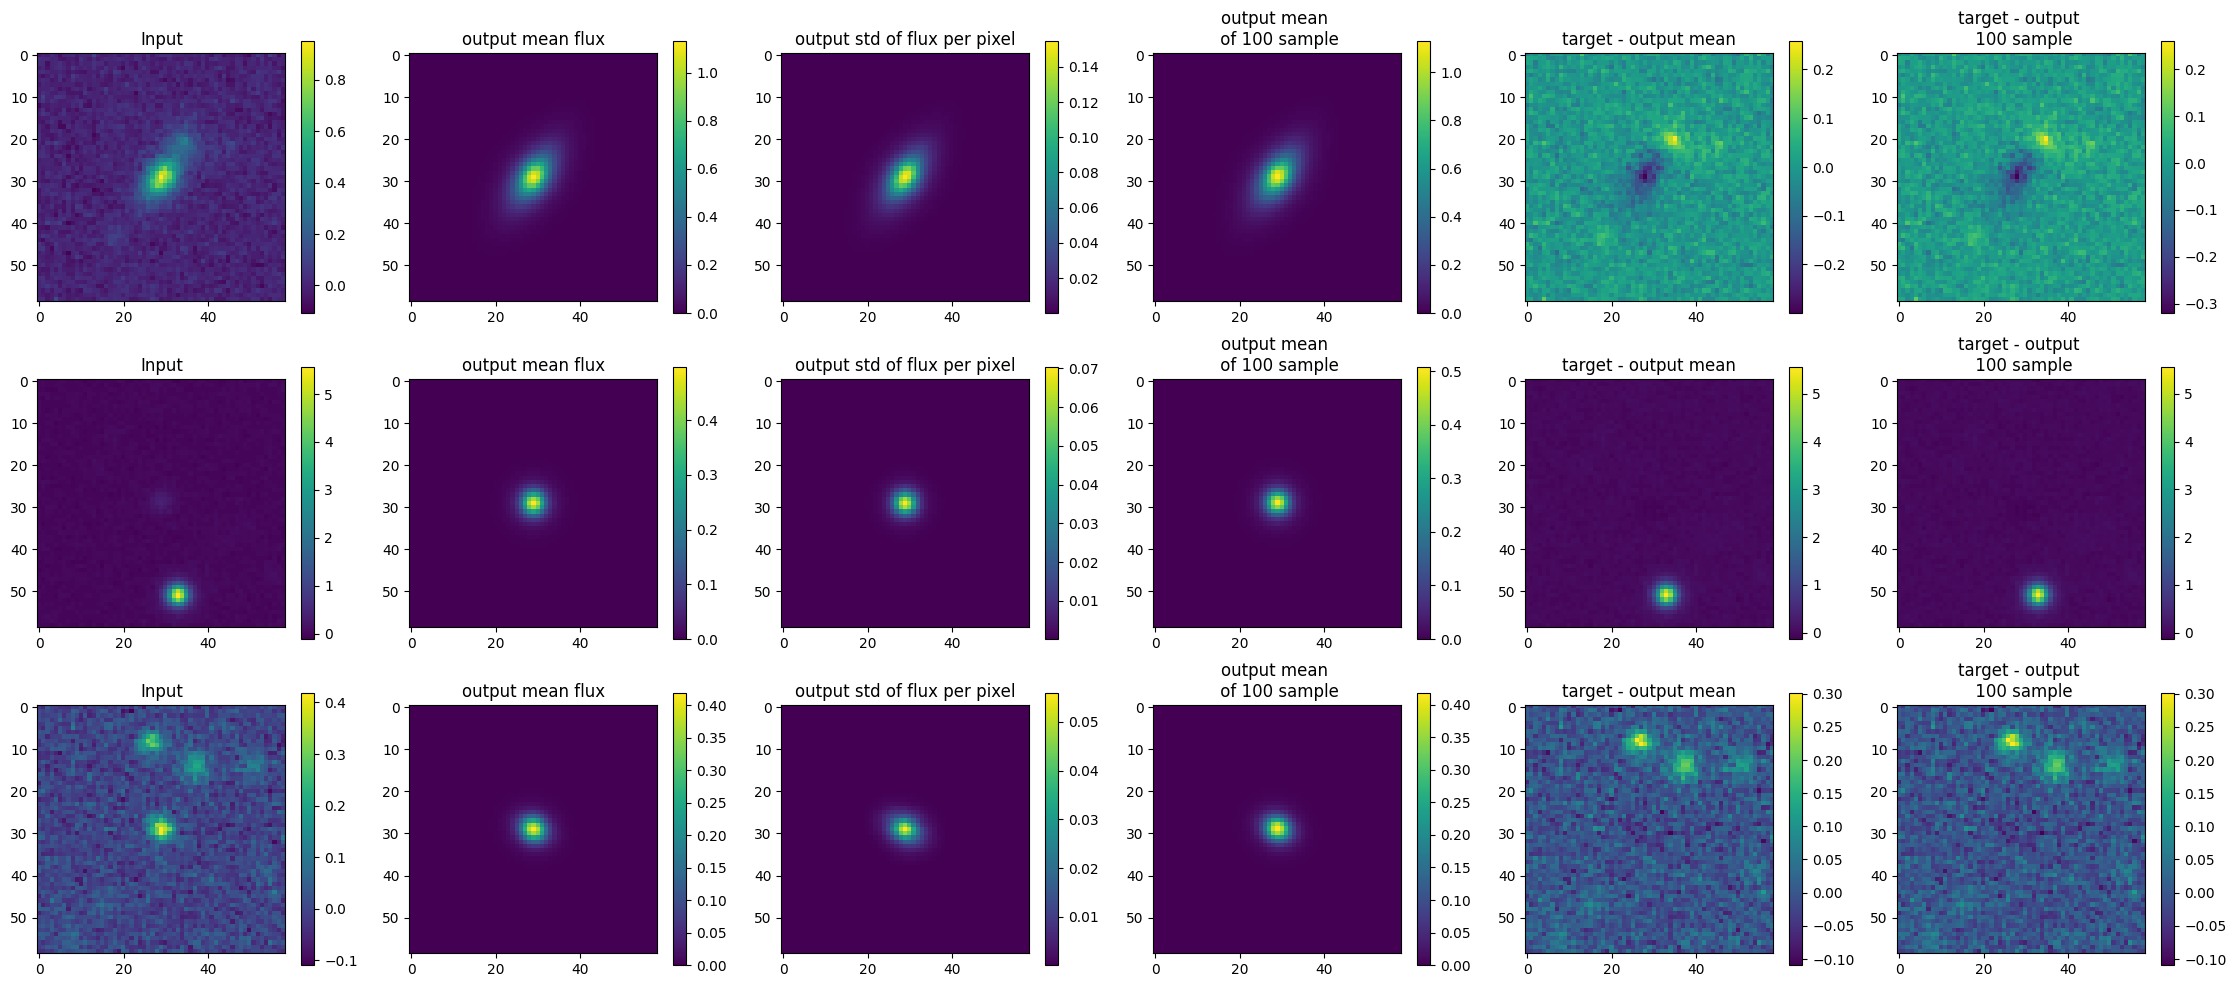

In [12]:
fig, axes = plt.subplots(3,6, figsize = (28, 12))

for i in range (3):
    f1 = axes[i,0].imshow(images[i,:,:,2])
    f2 = axes[i,1].imshow(output_uncertainty_mean[i,:,:,2])
    f3 = axes[i,2].imshow(output_uncertainty_std[i,:,:,2])
    f4 = axes[i,3].imshow(output_uncertainty_sample[i,:,:,2])
    f5 = axes[i,4].imshow(images[i,:,:,2] - output_uncertainty_mean[i,:,:,2])
    f6 = axes[i,5].imshow(images[i,:,:,2] - output_uncertainty_sample[i,:,:,2])
    fig.colorbar(f1, ax = axes[i,0])
    fig.colorbar(f2, ax = axes[i,1])
    fig.colorbar(f3, ax = axes[i,2])
    fig.colorbar(f4, ax = axes[i,3])
    fig.colorbar(f5, ax = axes[i,4])
    fig.colorbar(f6, ax = axes[i,5])

    axes[i,0].set_title('Input')
    axes[i,1].set_title('output mean flux')
    axes[i,2].set_title('output std of flux per pixel')
    axes[i,3].set_title('output mean \n of 100 sample')
    axes[i,4].set_title('target - output mean')
    axes[i,5].set_title('target - output \n 100 sample')

### Deblend a DC2 field

Load DC2 field image and corresponding galaxy stamps for galaxies that have a magnitude below 24.5 in the $r$-band, as well as the true galaxy centers on the field for galaxies with a magnitude below 26 in the $r$-band. They have been generated using this notebook: https://github.com/BastienArcelin/dc2_img_generation/blob/main/notebooks/dc2_stamps_and_corresponding_parameters.ipynb

In [13]:
import importlib.resources as pkg_resources
import os
import numpy as np

# Using importlib.resources to access the directory
with pkg_resources.files('debvader').joinpath('data') as data_folder_path:
    field_img_path = data_folder_path / 'dc2_imgs/field/field_img.npy'
    cutout_galaxy_img_path = data_folder_path / 'dc2_imgs/field/galaxies_from_field.npy'
    field_galaxies_distances_path = data_folder_path / 'dc2_imgs/field/ra_dec_coord.npy'
    all_field_galaxies_distances_truth_path = data_folder_path / 'dc2_imgs/field/gal_coordinates_complete_truth_catalog.npy'

    # Loading the files
    field_img = np.load(field_img_path, mmap_mode='c')
    cutout_galaxy_img = np.load(cutout_galaxy_img_path, mmap_mode='c')
    field_galaxies_distances_from_center = np.load(field_galaxies_distances_path, allow_pickle=True)
    all_field_galaxies_distances_from_center_truth = np.load(all_field_galaxies_distances_truth_path, allow_pickle=True)

# Make a copy of the field image
field_img_saving_iter = field_img.copy()

/tmp/ipykernel_90200/1928257524.py:6: DeprecationWarning: pathlib.Path.__enter__() is deprecated and scheduled for removal in Python 3.13; Path objects as a context manager is a no-op
  with pkg_resources.files('debvader').joinpath('data') as data_folder_path:


Set parameters:

In [14]:
cutout_size = 59 # pixels
field_size = 259 # pixels
nb_of_bands = 6 # six LSST filters

#### Detection with SExtractor

We can also use the very common detection algorithm [SExtractor](https://articles.adsabs.harvard.edu/pdf/1996A%26AS..117..393B). Using the `detect_objects` function we can detect all the galaxies that are above `0.8` times the noise level in the image.

In [15]:
galaxy_distances_to_center_sep = detect_objects(field_img)

In [16]:
print("Number of galaxies detected by SExtractor : "+ str(len(galaxy_distances_to_center_sep)))

Number of galaxies detected by SExtractor : 44


#### Deblending the field with SExtractor detected galaxy positions

Feed the deblend_field with the required paramter, including the coordinates of the sources detected by SExtractor:

In [17]:
Deblender = DeblendField(net, field_img)
res_deblending_sep = Deblender.deblend_field(galaxy_distances_to_center_sep)

Some galaxies are too close from the border of the field to be considered here.


In [18]:
res_deblending_sep_meta = Deblender.get_deblending_meta_data()

In [19]:
print('On the '+ str(Deblender.nb_of_detected_objects[0]) +' galaxies detected by SExtractor, '+ str(Deblender.nb_of_deblended_galaxies[0])+' were actually deblended.')

On the 44 galaxies detected by SExtractor, 31 were actually deblended.


The function outputs both the initial field and the field subtracted from the deblended galaxies. It also provide an image of the model proposed by the deblender for the denoised field.

Text(0.5, 1.0, 'Standard deviation of field composed of the deblended galaxies')

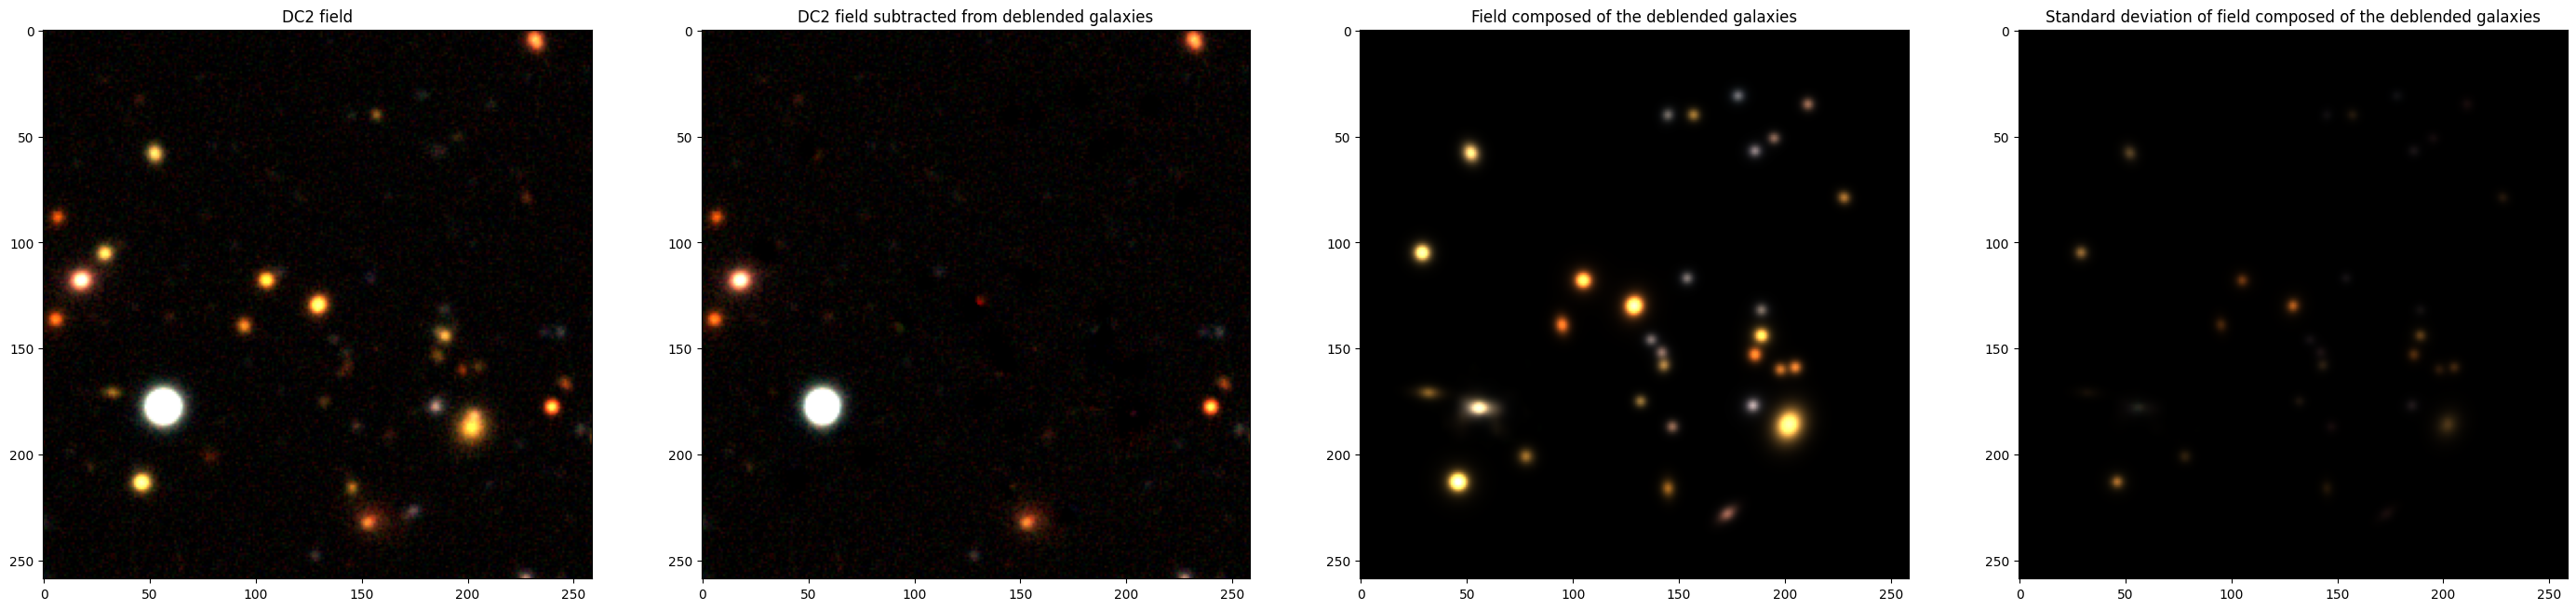

In [20]:
bands = [3,2,1]

fig, axes = plt.subplots(1,4, figsize = (35,15))
axes[0].imshow(np.clip(res_deblending_sep_meta['field_image'][0][:,:,bands], a_min=0.0, a_max=1.))
axes[1].imshow(np.clip(res_deblending_sep_meta['deblended_image'][0][:,:,bands], a_min=0.0, a_max=1.))
axes[2].imshow(np.clip(res_deblending_sep_meta['predicted_mean_field'][:,:,bands], a_min=0.0, a_max=1.))
axes[3].imshow(np.clip(res_deblending_sep_meta['predicted_stddev_field'][:,:,bands], a_min=0.0, a_max=1.))

axes[0].set_title('DC2 field')
axes[1].set_title('DC2 field subtracted from deblended galaxies')
axes[2].set_title('Field composed of the deblended galaxies')
axes[3].set_title('Standard deviation of field composed of the deblended galaxies')

We can see that there are still some residuals on the DC2 field subtracted from the deblended galaxies...

To improve this we can use the `optimize` module from `scipy` to look for the position that minimises the mean squared error between the true DC2 field and the one reconstructed from the deblended galaxies. For that we set the argument `optimise position` to **True**.

In [21]:
Deblender = DeblendField(net, field_img)
res_deblending_optimisation = Deblender.deblend_field(galaxy_distances_to_center_sep, optimise_positions=True)

Some galaxies are too close from the border of the field to be considered here.


In [22]:
res_deblending_optimisation_meta = Deblender.get_deblending_meta_data()

Text(0.5, 1.0, 'Standard deviation of field composed of the deblended galaxies')

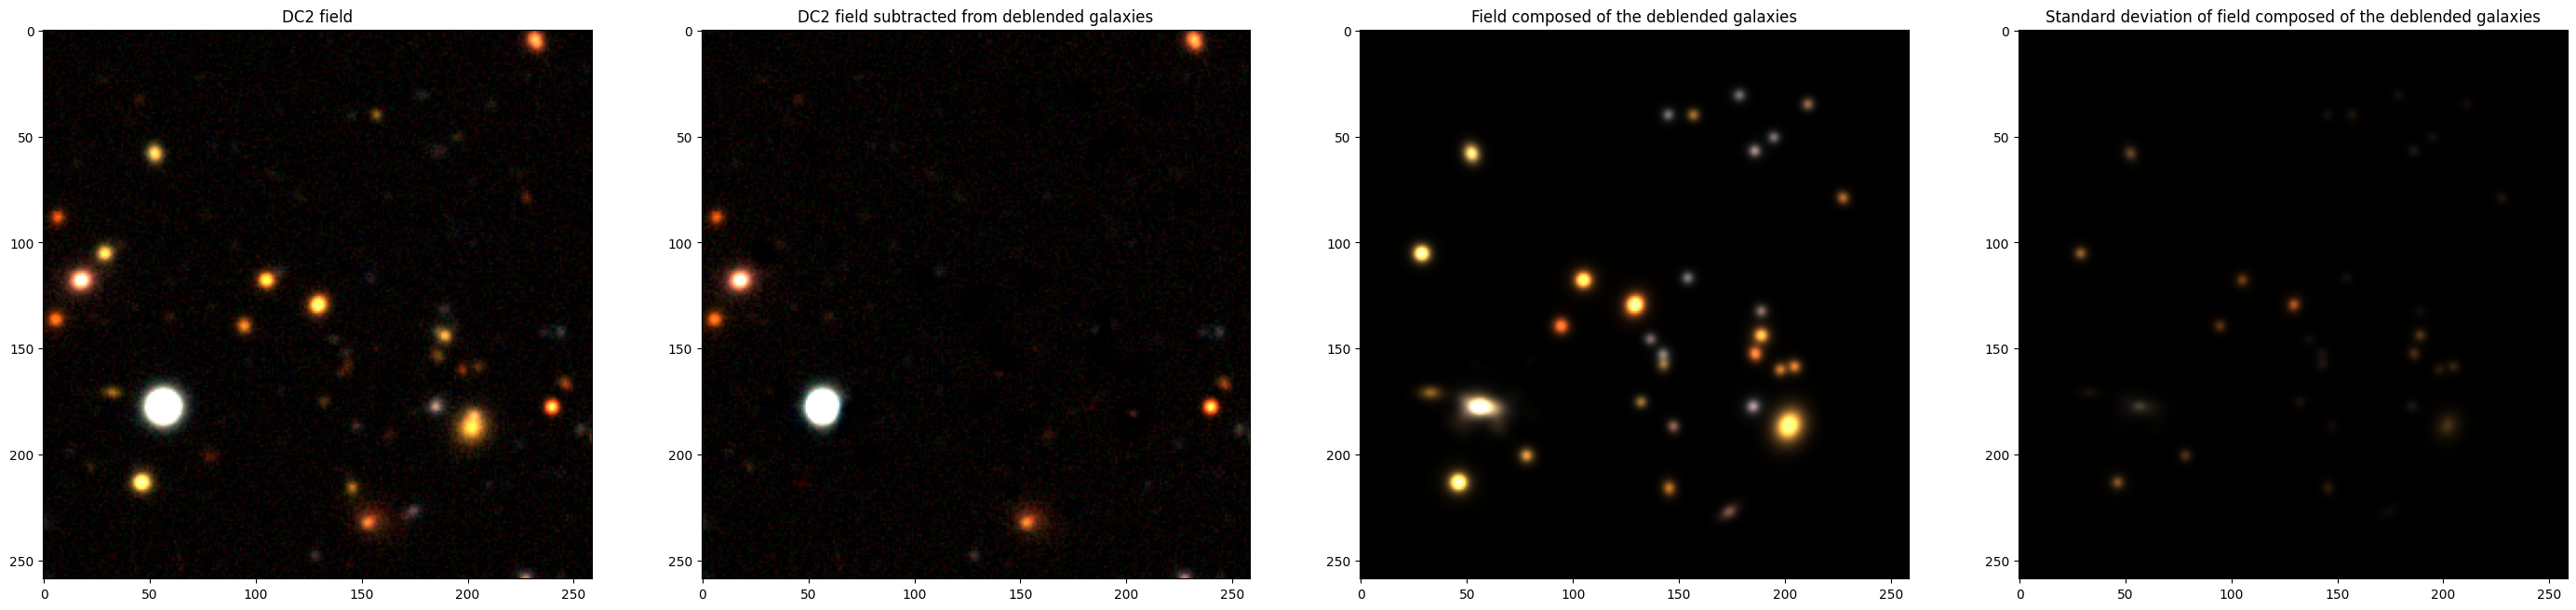

In [23]:
bands = [3,2,1]

fig, axes = plt.subplots(1,4, figsize = (35,15))
axes[0].imshow(np.clip(res_deblending_optimisation_meta['field_image'][0][:,:,bands], a_min=0.0, a_max=1.))
axes[1].imshow(np.clip(res_deblending_optimisation_meta['deblended_image'][0][:,:,bands], a_min=0.0, a_max=1.))
axes[2].imshow(np.clip(res_deblending_optimisation_meta['predicted_mean_field'][:,:,bands], a_min=0.0, a_max=1.))
axes[3].imshow(np.clip(res_deblending_optimisation_meta['predicted_stddev_field'][:,:,bands], a_min=0.0, a_max=1.))

axes[0].set_title('DC2 field')
axes[1].set_title('DC2 field subtracted from deblended galaxies')
axes[2].set_title('Field composed of the deblended galaxies')
axes[3].set_title('Standard deviation of field composed of the deblended galaxies')

We see that there are less residuals, for example for the galaxy below the bright star or for the bright ones in the of the field.

#### Comparison with DC2 truth catalog

For comparison we also take the coordinates of the galaxies from the truth catalog (with a magnitude cut at 26 in the $r$-band).

In [24]:
galaxies_coord_truth = all_field_galaxies_distances_from_center_truth
field_center = field_galaxies_distances_from_center[0]

In [25]:
galaxy_distances_to_center = []
for i in range(galaxies_coord_truth.shape[0]):
    galaxy_distances_to_center.append((int(-field_center[1]+galaxies_coord_truth[i][1]), int(-field_center[0]+galaxies_coord_truth[i][0])))

galaxy_distances_to_center=np.array(galaxy_distances_to_center)

In [26]:
print('There are '+str(len(galaxy_distances_to_center))+' galaxies that have a magnitude below 26 in the r-band on this field')

There are 43 galaxies that have a magnitude below 26 in the r-band on this field


Now do the deblending:

In [27]:
import time
t0 = time.time()
Deblender = DeblendField(net, field_img)
res_deblending = Deblender.deblend_field(galaxy_distances_to_center, optimise_positions=False)
print('The deblending of the field took '+str(time.time()-t0)+' seconds.')

Some galaxies are too close from the border of the field to be considered here.
The deblending of the field took 0.46964550018310547 seconds.


In [28]:
res_deblending_meta = Deblender.get_deblending_meta_data()

In [29]:
print('On the '+ str(Deblender.nb_of_detected_objects[0]) +' galaxies detected, '+str(Deblender.nb_of_deblended_galaxies[0]) +' were actually deblended.')

On the 43 galaxies detected, 37 were actually deblended.


And look at the resulting fields with red crosses superposed to the field on the positions of the galaxies from the truth catalog below a magnitude of 26 in the $r$-band.

Text(0.5, 1.0, 'Standard deviation of field composed of the deblended galaxies')

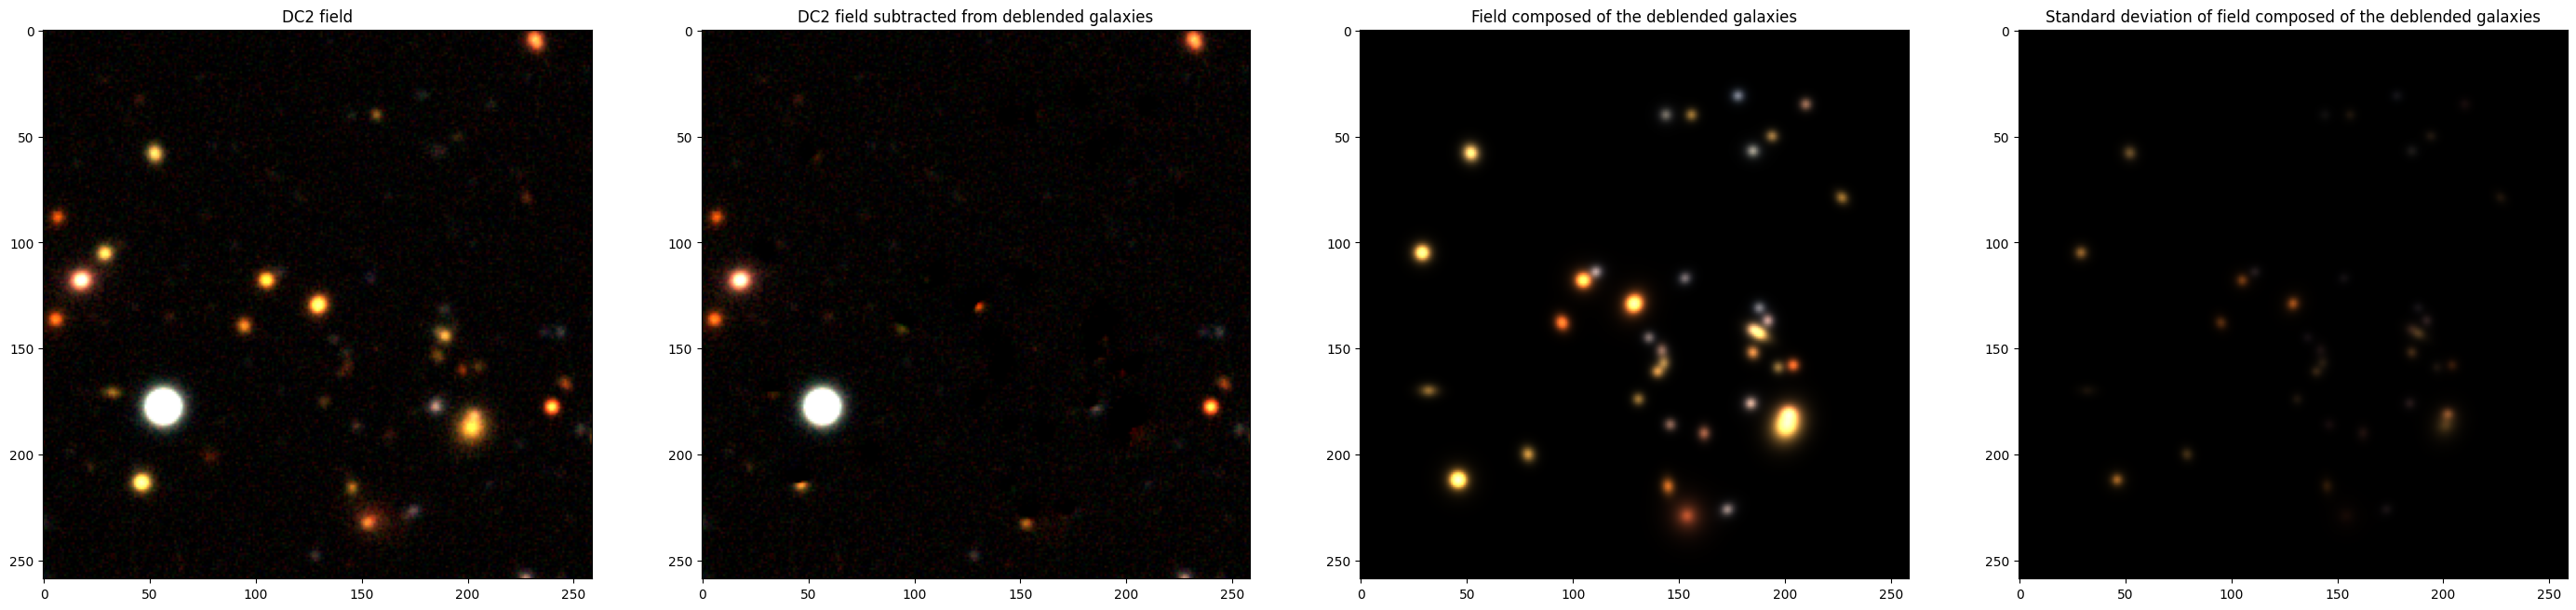

In [30]:
bands = [3,2,1]

fig, axes = plt.subplots(1,4, figsize = (35,15))
axes[0].imshow(np.clip(res_deblending_meta['field_image'][0][:,:,bands], a_min=0.0, a_max=1.))
axes[1].imshow(np.clip(res_deblending_meta['deblended_image'][0][:,:,bands], a_min=0.0, a_max=1.))
axes[2].imshow(np.clip(res_deblending_meta['predicted_mean_field'][:,:,bands], a_min=0.0, a_max=1.))
axes[3].imshow(np.clip(res_deblending_meta['predicted_stddev_field'][:,:,bands], a_min=0.0, a_max=1.))

axes[0].set_title('DC2 field')
axes[1].set_title('DC2 field subtracted from deblended galaxies')
axes[2].set_title('Field composed of the deblended galaxies')
axes[3].set_title('Standard deviation of field composed of the deblended galaxies')

Now we can check if we had the correct positions with SExtractor and compare the two deblended fields:

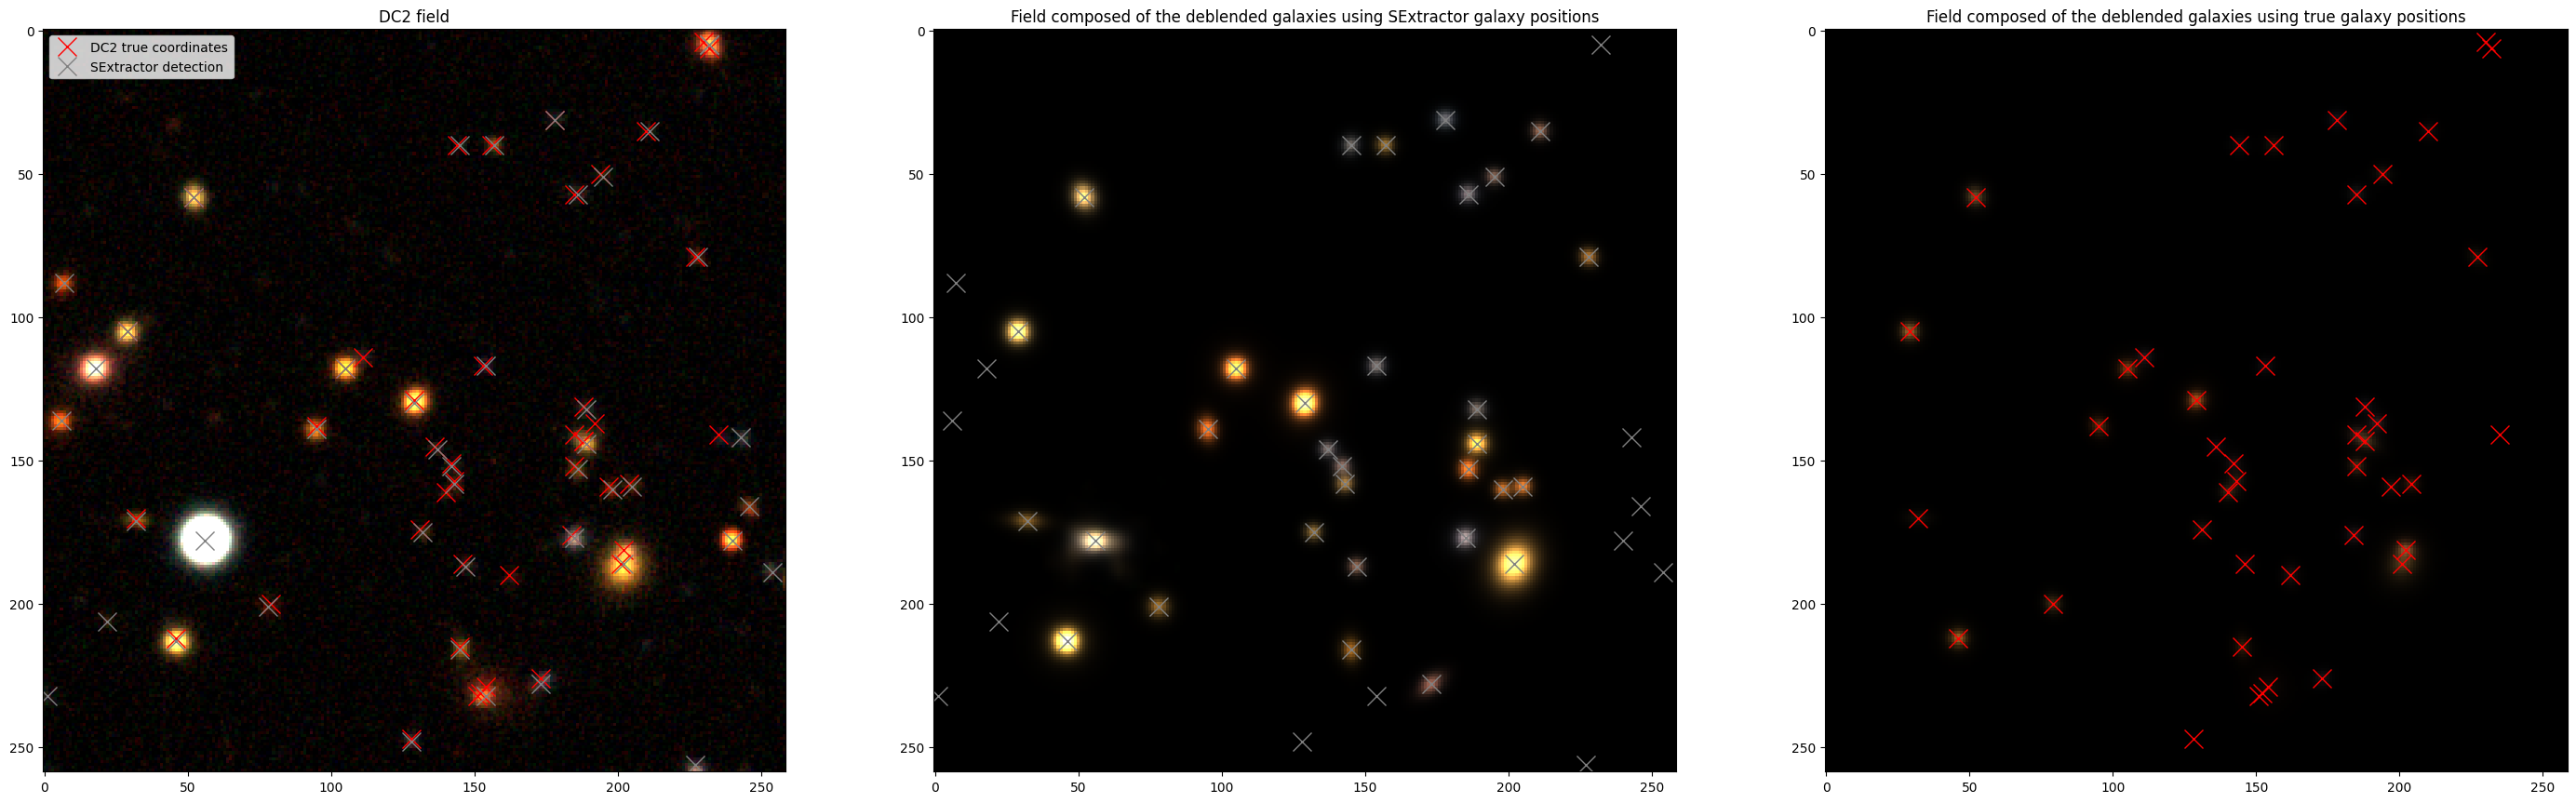

In [31]:
bands = [3,2,1]

fig, axes = plt.subplots(1,3, figsize = (35,15))
axes[0].imshow(np.clip(res_deblending_meta['field_image'][0][:,:,bands], a_min=0.0, a_max=1.))
axes[1].imshow(np.clip(res_deblending_sep_meta['predicted_mean_field'][:,:,bands], a_min=0.0, a_max=1.))
axes[2].imshow(np.clip(res_deblending_meta['predicted_stddev_field'][:,:,bands], a_min=0.0, a_max=1.))

for i in range(len(galaxy_distances_to_center)):
    if i==0:
        axes[0].plot(np.round(int(field_size/2)+galaxy_distances_to_center[i][1]),np.round(int(field_size/2)+galaxy_distances_to_center[i][0]), 'x', color = 'red', markersize = 15, label = 'DC2 true coordinates')
    axes[0].plot(np.round(int(field_size/2)+galaxy_distances_to_center[i][1]),np.round(int(field_size/2)+galaxy_distances_to_center[i][0]), 'x', color = 'red', markersize = 15)
    axes[2].plot(np.round(int(field_size/2)+galaxy_distances_to_center[i][1]),np.round(int(field_size/2)+galaxy_distances_to_center[i][0]), 'x', color = 'red', markersize = 15)
for i in range(len(galaxy_distances_to_center_sep)):
    if i==0:
        axes[0].plot(np.round(int(field_size/2)+galaxy_distances_to_center_sep[i][1]),np.round(int(field_size/2)+galaxy_distances_to_center_sep[i][0]), 'x', color = 'grey', markersize = 15, label = 'SExtractor detection')
    axes[0].plot(np.round(int(field_size/2)+galaxy_distances_to_center_sep[i][1]),np.round(int(field_size/2)+galaxy_distances_to_center_sep[i][0]), 'x', color = 'grey', markersize = 15)
    axes[1].plot(np.round(int(field_size/2)+galaxy_distances_to_center_sep[i][1]),np.round(int(field_size/2)+galaxy_distances_to_center_sep[i][0]), 'x', color = 'grey', markersize = 15)

axes[0].set_title('DC2 field')
axes[1].set_title('Field composed of the deblended galaxies using SExtractor galaxy positions')
axes[2].set_title('Field composed of the deblended galaxies using true galaxy positions')
axes[0].legend()

So we see that SExtractor found most of the true galaxies that have a magnitude below 26 in the $r$-band, and even some with at larger magnitudes. However, it fails for some of them, mostly when two galaxies are very close from one another (see in the lower right and in the middle at the bright galaxy for example). To find these residuals galaxies, we need to use an iterative procedure, re-running the detection on the denoised field to see if there are any remaining galaxies that became detectable after the first deblending pass.

**Note**: it is also possible to provide the cutout images directly to the deblended function is you already have extracted them using another algorithm. To do so, you must feed them to the `cutout_images` argument as shown below:

### Iterative deblending

With `debvader` it is possible to use the `iterative_deblending` function.

This method extracts the galaxies iteratively. In the example below, no coordinates are provided as first step, but it can be done by feeding them to the `galaxy_distances_to_center` argument.

#### Iterative deblending with SExtractor 

In [32]:
import time
t0=time.time()
IterativeDeblender = IterativeDeblendField(net, field_img)
res_iterative_procedure = IterativeDeblender.iterative_deblending(optimise_positions=False)
print('time: '+str(time.time()-t0))

Some galaxies are too close from the border of the field to be considered here.
Deblend 31 more galaxy(ies)
iteration 1
Some galaxies are too close from the border of the field to be considered here.
Deblend 8 more galaxy(ies)
39 galaxies found up to this step.
deta_mse = -1, mse_iteration = 0.011085025402601619 and mse_previous_step = 0.012255358035448345
converged !
time: 1.3570127487182617


In [ ]:
res_iterative_procedure_meta = IterativeDeblender.get_deblending_meta_data()

In [ ]:
np.array(res_iterative_procedure['output_images_mean']).shape

We have deblended 5 more galaxies than with a single path. We can compare with the previously deblended field.

In [ ]:
bands = [3,2,1]

fig, axes = plt.subplots(1,4, figsize = (45,15))
axes[0].imshow(np.clip(res_iterative_procedure_meta['field_image'][0][:,:,bands], a_min=0.0, a_max=1.))
axes[1].imshow(np.clip(res_iterative_procedure_meta['predicted_mean_field'][:,:,bands], a_min=0.0, a_max=1.))
axes[2].imshow(np.clip(res_deblending_sep_meta['predicted_mean_field'][:,:,bands], a_min=0.0, a_max=1.))
axes[3].imshow(np.clip(res_iterative_procedure_meta['predicted_stddev_field'][:,:,bands]- res_deblending_sep_meta['predicted_mean_field'][:,:,bands], a_min=0.0, a_max=1.))

axes[0].set_title('DC2 field')
axes[1].set_title('Field composed of the deblended galaxies with iterative procedure')
axes[2].set_title('Field composed of the deblended galaxies with a single pass of SExtractor')
axes[3].set_title('Field composed of the deblended galaxies with iterative procedure\n minus the one with a single pass of SExtractor')

In [ ]:
bands = [3,2,1]

fig, axes = plt.subplots(1,3, figsize = (45,15))
axes[0].imshow(np.clip(res_iterative_procedure_meta['field_image'][0][:,:,bands], a_min=0.0, a_max=1.))
axes[1].imshow(np.clip(res_iterative_procedure_meta['predicted_mean_field'][:,:,bands], a_min=0.0, a_max=1.))
axes[2].imshow(np.clip(res_iterative_procedure_meta['predicted_mean_field'][:,:,bands]- res_deblending_sep_meta['predicted_mean_field'][:,:,bands], a_min=0.0, a_max=1.))

axes[0].set_title('DC2 field')
axes[1].set_title('Field composed of the deblended galaxies with iterative procedure')
axes[2].set_title('Field composed of the deblended galaxies with iterative procedure\n minus the one with a single pass of SExtractor')

for i in range(len(galaxy_distances_to_center)):
    if i==0:
        axes[2].plot(np.round(int(field_size/2)+galaxy_distances_to_center[i][1]),np.round(int(field_size/2)+galaxy_distances_to_center[i][0]), 'x', color = 'red', markersize = 15, label = 'DC2 true coordinates')        
    axes[2].plot(np.round(int(field_size/2)+galaxy_distances_to_center[i][1]),np.round(int(field_size/2)+galaxy_distances_to_center[i][0]), 'x', color = 'red', markersize = 15)


Interestingly, as shown on the previous plot on the right, these six galaxies are true galaxies from the DC2 simulation (TO CONFIRM WITH DC2 DATA). We consequently increased our number of usable galaxies by 5 compared to 36 before. A $14$% increase in the number of usable galaxies.

It is also possible to access simply the different cutouts and the deblended galaxies from the cutouts. We plot only r-band here, but the output images are multi-bands (ugrizy)::

In [ ]:
fig, axes = plt.subplots(10,3, figsize = (10, 50))
for i in range (10):
    f1 = axes[i,0].imshow(res_iterative_procedure['cutout_images'][i][:,:,2])
    f2 = axes[i,1].imshow(res_iterative_procedure['output_images_mean'][i][:,:,2])
    f3 = axes[i,2].imshow(res_iterative_procedure['cutout_images'][i][:,:,2]-res_iterative_procedure['output_images_mean'][i][:,:,2])
    
    fig.colorbar(f1, ax = axes[i,0])
    fig.colorbar(f2, ax = axes[i,1])
    fig.colorbar(f3, ax = axes[i,2])
    
    axes[i,0].set_title('Input')
    axes[i,1].set_title('output mean')
    axes[i,2].set_title('Input - output mean')

#### Two other DC2 field examples

Here we show the example for two other fields taken randomly within the DC2 simulation.

##### First example

In [ ]:
import importlib.resources as pkg_resources
import numpy as np
from debvader import IterativeDeblendField

# Define data path using importlib.resources (Python 3.9+)
with pkg_resources.files('debvader').joinpath('data') as data_folder_path:
    # Use / for joining paths with PosixPath objects
    field_img_path = data_folder_path / 'dc2_imgs/field/field_img_2.npy'
    distances_truth_path = data_folder_path / 'dc2_imgs/field/gal_coordinates_complete_truth_catalog_2.npy'
    field_center_path = data_folder_path / 'dc2_imgs/field/field_center_2.npy'

    # Load images and data
    field_img = np.load(field_img_path, mmap_mode='c')
    all_field_galaxies_distances_from_center_truth = np.load(distances_truth_path, allow_pickle=True)
    field_center = np.load(field_center_path)

# Initialize and run IterativeDeblender
IterativeDeblender = IterativeDeblendField(net, field_img, epistemic_uncertainty_estimation=False)
res_iterative_procedure = IterativeDeblender.iterative_deblending(
    galaxy_distances_to_center=None,
    optimise_positions=True,
    epistemic_criterion=20,
    mse_criterion=0.5
)
res_iterative_procedure_meta = IterativeDeblender.get_deblending_meta_data()


In [ ]:
bands = [3,2,1]

fig, axes = plt.subplots(1,4, figsize = (45,15))
axes[0].imshow(np.clip(res_iterative_procedure_meta['field_image'][0][:,:,bands], a_min=0.0, a_max=1.))
axes[1].imshow(np.clip(res_iterative_procedure_meta['deblended_image'][0][:,:,bands], a_min=0.0, a_max=1.))
axes[2].imshow(np.clip(res_iterative_procedure_meta['predicted_mean_field'][:,:,bands], a_min=0.0, a_max=1.))
axes[3].imshow(np.clip(res_iterative_procedure_meta['predicted_stddev_field'][:,:,bands], a_min=0.0, a_max=1.))
#axes[4].imshow(np.clip(res_iterative_procedure['model_image_epistemic_uncertainty'][:,:,bands], a_min=0.0, a_max=1.))

axes[0].set_title('DC2 field')
axes[1].set_title('DC2 field subtracted from deblended galaxies')
axes[2].set_title('Field composed of the deblended galaxies')
axes[3].set_title('Standard deviation of field composed of the deblended galaxies')
#axes[4].set_title('Epistemic uncertainty of field composed of the deblended galaxies')

In [ ]:
galaxy_distances_to_center = []
for i in range(all_field_galaxies_distances_from_center_truth.shape[0]):
    galaxy_distances_to_center.append((int(np.round(-field_center[1]+all_field_galaxies_distances_from_center_truth[i][1])), int(np.round(-field_center[0]+all_field_galaxies_distances_from_center_truth[i][0]))))

galaxy_distances_to_center=np.array(galaxy_distances_to_center)

In [ ]:
bands = [3,2,1]

fig, axes = plt.subplots(1,4, figsize = (35,15))
axes[0].imshow(np.clip(res_iterative_procedure_meta['field_image'][0][:,:,bands], a_min=0.0, a_max=1.))
axes[1].imshow(np.clip(res_iterative_procedure_meta['deblended_image'][0][:,:,bands], a_min=0.0, a_max=1.))
axes[2].imshow(np.clip(res_iterative_procedure_meta['predicted_mean_field'][:,:,bands], a_min=0.0, a_max=1.))
axes[3].imshow(np.clip(res_iterative_procedure_meta['predicted_stddev_field'][:,:,bands], a_min=0.0, a_max=1.))

for i in range(len(galaxy_distances_to_center)):
    axes[0].plot(np.round(int(field_size/2)+galaxy_distances_to_center[i][1]),np.round(int(field_size/2)+galaxy_distances_to_center[i][0]), 'x', color = 'red', markersize = 15)
    axes[1].plot(np.round(int(field_size/2)+galaxy_distances_to_center[i][1]),np.round(int(field_size/2)+galaxy_distances_to_center[i][0]), 'x', color = 'red', markersize = 15)
    axes[2].plot(np.round(int(field_size/2)+galaxy_distances_to_center[i][1]),np.round(int(field_size/2)+galaxy_distances_to_center[i][0]), 'x', color = 'red', markersize = 15)


axes[0].set_title('DC2 field')
axes[1].set_title('DC2 field subtracted from deblended galaxies')
axes[2].set_title('Field composed of the deblended galaxies')
axes[3].set_title('Standard deviation of field composed of the deblended galaxies')

##### Second example

In [ ]:
import importlib.resources as pkg_resources
import numpy as np
from debvader import IterativeDeblendField

# Define data path using importlib.resources (Python 3.9+)
with pkg_resources.files('debvader').joinpath('data') as data_folder_path:
    field_img_path = data_folder_path / 'dc2_imgs/field/field_img_3.npy'
    distances_truth_path = data_folder_path / 'dc2_imgs/field/gal_coordinates_complete_truth_catalog_3.npy'
    field_center_path = data_folder_path / 'dc2_imgs/field/field_center_3.npy'

    # Load images and data
    field_img = np.load(field_img_path, mmap_mode='c')
    all_field_galaxies_distances_from_center_truth = np.load(distances_truth_path, allow_pickle=True)
    field_center = np.load(field_center_path)


In [ ]:
bands = [3,2,1]

fig, axes = plt.subplots(1,4, figsize = (45,15))
axes[0].imshow(np.clip(res_iterative_procedure_meta['field_image'][0][:,:,bands], a_min=0.0, a_max=1.))
axes[1].imshow(np.clip(res_iterative_procedure_meta['deblended_image'][0][:,:,bands], a_min=0.0, a_max=1.))
axes[2].imshow(np.clip(res_iterative_procedure_meta['predicted_mean_field'][:,:,bands], a_min=0.0, a_max=1.))
axes[3].imshow(np.clip(res_iterative_procedure_meta['predicted_stddev_field'][:,:,bands], a_min=0.0, a_max=1.))
#axes[4].imshow(np.clip(res_iterative_procedure['model_image_epistemic_uncertainty'][:,:,bands], a_min=0.0, a_max=1.))

axes[0].set_title('DC2 field')
axes[1].set_title('DC2 field subtracted from deblended galaxies')
axes[2].set_title('Field composed of the deblended galaxies')
axes[3].set_title('Standard deviation of field composed of the deblended galaxies')
#axes[4].set_title('Epistemic uncertainty of field composed of the deblended galaxies')

In [ ]:
galaxy_distances_to_center = []
for i in range(all_field_galaxies_distances_from_center_truth.shape[0]):
    galaxy_distances_to_center.append((int(-field_center[1]+all_field_galaxies_distances_from_center_truth[i][1]), int(-field_center[0]+all_field_galaxies_distances_from_center_truth[i][0])))

galaxy_distances_to_center=np.array(galaxy_distances_to_center)

In [ ]:
bands = [3,2,1]

fig, axes = plt.subplots(1,4, figsize = (35,15))
axes[0].imshow(np.clip(res_iterative_procedure_meta['field_image'][0][:,:,bands], a_min=0.0, a_max=1.))
axes[1].imshow(np.clip(res_iterative_procedure_meta['deblended_image'][0][:,:,bands], a_min=0.0, a_max=1.))
axes[2].imshow(np.clip(res_iterative_procedure_meta['predicted_mean_field'][:,:,bands], a_min=0.0, a_max=1.))
axes[3].imshow(np.clip(res_iterative_procedure_meta['predicted_stddev_field'][:,:,bands], a_min=0.0, a_max=1.))

for i in range(len(galaxy_distances_to_center)):
    axes[0].plot(np.round(int(field_size/2)+galaxy_distances_to_center[i][1]),np.round(int(field_size/2)+galaxy_distances_to_center[i][0]), 'x', color = 'red', markersize = 15)
    axes[1].plot(np.round(int(field_size/2)+galaxy_distances_to_center[i][1]),np.round(int(field_size/2)+galaxy_distances_to_center[i][0]), 'x', color = 'red', markersize = 15)
    axes[2].plot(np.round(int(field_size/2)+galaxy_distances_to_center[i][1]),np.round(int(field_size/2)+galaxy_distances_to_center[i][0]), 'x', color = 'red', markersize = 15)


axes[0].set_title('DC2 field')
axes[1].set_title('DC2 field subtracted from deblended galaxies')
axes[2].set_title('Field composed of the deblended galaxies')
axes[3].set_title('Standard deviation of field composed of the deblended galaxies')